In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

## Load dataset

In [2]:
incident_data = pd.read_csv("incidents.csv")
event_data = pd.read_csv("events.csv")
coordinate_data = pd.read_csv("coordinates.csv")


event_data.head(20)
coordinate_data.head(20)
incident_data.head(20)

,_id,type,properties_id,properties_iconCategory,properties_magnitudeOfDelay,properties_startTime,properties_endTime,properties_from,properties_to,properties_length,properties_delay,properties_aci,geometry_type
0,60854a2aadbe3a63a8cea480,Feature,b02cb3b91efabe2e3d945b35bb3ac9d9,8,4,2020-03-30T14:29:30Z,NaN,Rua Dom Pedro IV (N117),Rua Elias Garcia (N117),341.178000,0,NaN,LineString
1,60854a2badbe3a63a8cea481,Feature,79b7ffce40e6ac525dd5295547e134c3,8,4,2021-04-22T21:07:30Z,NaN,Alameda Hermano Patrone (N117) / Rua Major Afo...,Rua Doutor António Granjo,120.725078,0,NaN,LineString
2,60854a2badbe3a63a8cea482,Feature,dc03a766e0a03ab58636d17c0275e991,6,3,2021-04-25T10:34:30Z,2021-04-25T11:13:00Z,Avenida Adolfo Casais Monteiro,Praça José Escada,107.080680,68,NaN,LineString
3,60854a2badbe3a63a8cea483,Feature,3ffd6a8f0922eb647fec3e782b6cbef7,6,2,2021-04-25T10:48:00Z,2021-04-25T11:14:00Z,Brandoa,Rua Luís Pinto Coelho,235.898481,184,NaN,LineString
4,60854a2badbe3a63a8cea484,Feature,6da03a2343c1ea1f6df542dce0464705,6,3,2021-04-25T09:42:30Z,2021-04-25T11:13:00Z,Rua da Quinta do Pinheiro,Rua da Quinta do Paizinho,310.632538,138,NaN,LineString
5,60854a2badbe3a63a8cea485,Feature,5ac8335a95b104be4bd2765a00cbc3fb,6,2,2021-04-25T09:10:00Z,2021-04-25T11:13:00Z,Rua da Quinta do Paizinho,N117,385.583589,67,NaN,LineString
6,60854a2badbe3a63a8cea486,Feature,3472a310822428ecf9e108a4f2020f20,6,3,2021-04-25T08:51:30Z,2021-04-25T11:14:00Z,exit [5],N117,566.984458,228,NaN,LineString
7,60854a2badbe3a63a8cea487,Feature,177f79c5945aa14bfaf3c514442e107f,6,2,2021-04-25T06:51:30Z,2021-04-25T11:13:00Z,Estrada Dos Salgados (Estrada Da Brandoa),Avenida Ruy Luís Gomes (Estrada Da Brandoa),512.498297,107,NaN,LineString
8,60854a2badbe3a63a8cea488,Feature,a5c3f205e271d2b3abd57cd872376756,8,4,2021-04-25T07:00:00Z,2021-04-25T19:00:00Z,Ajuda,Calçada do Galvão,113.214008,0,NaN,LineString
9,60854a2cadbe3a63a8cea489,Feature,f44d8ff31eb82184d8ee8ca2f6d2cd8b,8,4,2021-04-25T07:00:00Z,2021-04-25T19:00:00Z,Calçada do Galvão,Ajuda,113.214008,0,NaN,LineString


## Preprocess dataset

In [3]:
incident_data.isnull().sum()
incident_data.drop(incident_data.columns[[0,1,2,4,6,9,10,11,12]], axis=1, inplace=True) # endtime é 6
incident_data = incident_data.dropna() # Para ter a certeza que não há valores nulos
incident_data.isnull().sum()

properties_iconCategory    0
properties_startTime       0
properties_from            0
properties_to              0
dtype: int64

## Create training and test data

In [4]:
def new_train_test_sets():
    
    msk = np.random.rand(len(incident_data)) < 0.8

    train_data = incident_data[msk] # 80% of data
    test_data = incident_data[~msk] # 20% of data
    train_data.value_counts()
    
    return (train_data,test_data)

## Turning non-numerical values into numerical

In [5]:
class MultiColumnLabelEncoder:

    def __init__(self, columns=None):
        self.columns = columns # array of column names to encode


    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self


    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output


    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)


    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output

    
def encodeData(train_data,test_data):
    
    multi = MultiColumnLabelEncoder(columns=['properties_iconCategory','properties_startTime','properties_from','properties_to'])
    new_train_data = multi.fit_transform(train_data)
    new_test_data = multi.fit_transform(test_data)   
    
    return (new_train_data,new_test_data)


### Normalizing data

In [6]:
def normalizeData(train_data,test_data):

    scaler = MinMaxScaler(feature_range=(0, 1))

    for i in ['properties_iconCategory','properties_startTime','properties_from','properties_to']:
    
        train_data[[i]] = scaler.fit_transform(train_data[[i]])
        test_data[[i]] = scaler.fit_transform(test_data[[i]])

In [7]:
def print_series_prediction(y_test,predic):
    plt.plot(y_test,color='blue', label='y_test')
    plt.plot(predic,color='red', label='prediction')
    plt.legend(loc='upper left')
    plt.show()

def knn_classifier(datasets):
    
    (X_train,y_train,X_test,y_test) = datasets
    
    model = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
    predictions = model.predict(X_test)
    df = pd.DataFrame({'actual':y_test,'predicted':predictions})
    print(df)
    print(accuracy_score(df['actual'], df['predicted']))
    print_series_prediction(y_test,df['predicted'])
    


In [8]:
# Treino
def data_startTime():
    
    (temp_train_data,temp_test_data) = new_train_test_sets()
    (train_data,test_data) = encodeData(temp_train_data,temp_test_data)
    
    normalizeData(train_data,test_data)
    
    c1 = train_data.value_counts('properties_startTime')

    rows = []

    for index, value in c1.items():
    
         rows.append([index, value])

    df = pd.DataFrame(rows, columns=["properties_startTime", "num_incidents"])
    X_train = df.drop(['num_incidents'],axis=1).values
    y_train = df['num_incidents'].values


    # Teste
    c2 = test_data.value_counts('properties_startTime')

    rows2 = []

    for index, value in c2.items():
    
         rows2.append([index, value])

    tmp_time = pd.DataFrame(rows, columns=["properties_startTime", "num_incidents"])
    X_test = tmp_time.drop(['num_incidents'],axis=1).values
    y_test = tmp_time['num_incidents'].values
    
    return (X_train,y_train,X_test,y_test)

In [9]:
def data_iconCategory():
    
    (temp_train_data,temp_test_data) = new_train_test_sets()
    (train_data,test_data) = encodeData(temp_train_data,temp_test_data)
    
    normalizeData(train_data,test_data)
    
    c1 = train_data.value_counts('properties_iconCategory')

    rows = []

    for index, value in c1.items():
    
         rows.append([index, value])

    df = pd.DataFrame(rows, columns=["properties_iconCategory", "num_incidents"])
    X_train = df.drop(['num_incidents'],axis=1).values
    y_train = df['num_incidents'].values


    # Teste
    c2 = test_data.value_counts('properties_iconCategory')

    rows2 = []

    for index, value in c2.items():
    
         rows2.append([index, value])

    tmp_time = pd.DataFrame(rows, columns=["properties_iconCategory", "num_incidents"])
    X_test = tmp_time.drop(['num_incidents'],axis=1).values
    y_test = tmp_time['num_incidents'].values
    
    return (X_train,y_train,X_test,y_test)

In [10]:
def data_from():
    
    (temp_train_data,temp_test_data) = new_train_test_sets()
    (train_data,test_data) = encodeData(temp_train_data,temp_test_data)
    
    normalizeData(train_data,test_data)
    
    c1 = train_data.value_counts('properties_from')

    rows = []

    for index, value in c1.items():
    
         rows.append([index, value])

    df = pd.DataFrame(rows, columns=["properties_from", "num_incidents"])
    X_train = df.drop(['num_incidents'],axis=1).values
    y_train = df['num_incidents'].values


    # Teste
    c2 = test_data.value_counts('properties_from')

    rows2 = []

    for index, value in c2.items():
    
         rows2.append([index, value])

    tmp_time = pd.DataFrame(rows, columns=["properties_from", "num_incidents"])
    X_test = tmp_time.drop(['num_incidents'],axis=1).values
    y_test = tmp_time['num_incidents'].values
    
    return (X_train,y_train,X_test,y_test)

In [54]:
def data_to():
    
    (temp_train_data,temp_test_data) = new_train_test_sets()
    (train_data,test_data) = encodeData(temp_train_data,temp_test_data)
    
    normalizeData(train_data,test_data)
    
    c1 = train_data.value_counts('properties_to')

    rows = []

    for index, value in c1.items():
    
         rows.append([index, value])

    df = pd.DataFrame(rows, columns=["properties_to", "num_incidents"])
    X_train = df.drop(['num_incidents'],axis=1).values
    y_train = df['num_incidents'].values


    # Teste
    c2 = test_data.value_counts('properties_to')

    rows2 = []

    for index, value in c2.items():
    
         rows2.append([index, value])

    tmp_time = pd.DataFrame(rows, columns=["properties_to", "num_incidents"])
    X_test = tmp_time.drop(['num_incidents'],axis=1).values
    y_test = tmp_time['num_incidents'].values
    
    return (X_train,y_train,X_test,y_test)

In [94]:
def searchData(spec_date):
    (train_data,test_data) = new_train_test_sets()
    
    # Treino
    
    rows = []
    # Formatar
    for i in range(len(train_data)):
        s = train_data.iloc[i, 1]
        date = s.split('T')[0]
        hour = (s.split('T')[1]).split(':')[0]
        res = date + " " + hour
        rows.append([res])
        
    tmp_time1 = pd.DataFrame(rows, columns=["Date"])
    serie = tmp_time1.value_counts("Date")
    
    rows2 = []
    
    # Construir dataframe e contar incidentes
    for index, value in serie.items():
    
         rows2.append([index, value])
    
    tmp_time2 = pd.DataFrame(rows2, columns=["Date","num_incidents"])
    
    # Construir dataframe com dia escolhido
    
    rows4 = []
    
    for i in range(len(tmp_time2)):
        
        s1 = tmp_time2.iloc[i, 0]
        s2 = tmp_time2.iloc[i, 1]
        if spec_date == s1.split(' ')[0]:
            
            rows4.append([s1,s2])
    
    # Teste
    
    rows5 = []
       
    # Formatar
    for i in range(len(test_data)):
        s = test_data.iloc[i, 1]
        date = s.split('T')[0]
        hour = (s.split('T')[1]).split(':')[0]
        res = date + " " + hour
        rows5.append([res])
        
    tmp_time3 = pd.DataFrame(rows5, columns=["Date"])
    serie1 = tmp_time1.value_counts("Date")
    
    rows6 = []
    
    # Construir dataframe e contar incidentes
    for index, value in serie1.items():
    
         rows6.append([index, value])
    
    tmp_time4 = pd.DataFrame(rows6, columns=["Date","num_incidents"])
    
    # Construir dataframe com dia escolhido

    rows8 = []
    
    for i in range(len(tmp_time4)):
        
        s1 = tmp_time4.iloc[i, 0]
        s2 = tmp_time4.iloc[i, 1]
        if spec_date == s1.split(' ')[0]:
            
            rows8.append([s1,s2])
    
    res = pd.DataFrame(rows4, columns=["Date", "num_incidents_hour"])
    
    res1 = pd.DataFrame(rows8, columns=["Date", "num_incidents_hour"])
    
    multi = MultiColumnLabelEncoder(columns=['Date','num_incidents_hour'])
    
    res2 = multi.fit_transform(res)
    res3 = multi.fit_transform(res1)
        
    X_train = res2.drop(['num_incidents_hour'],axis=1).values
    y_train = res2['num_incidents_hour'].values
    
    X_test = res3.drop(['num_incidents_hour'],axis=1).values
    y_test = res3['num_incidents_hour'].values
    
    return(X_train,y_train,X_test,y_test)

   actual  predicted
0   14089         12
1     313         12
2      12         12
0.3333333333333333


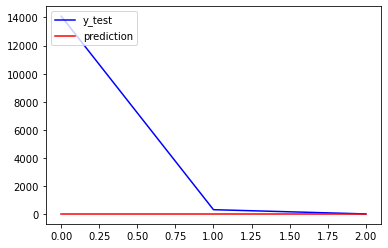

      actual  predicted
0         96          1
1         50         21
2         46         12
3         41          1
4         33          6
...      ...        ...
8015       1          1
8016       1          1
8017       1          1
8018       1          1
8019       1          1

[8020 rows x 2 columns]
0.7519950124688279


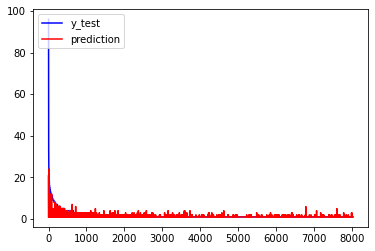

      actual  predicted
0        203         11
1        198         19
2        151          1
3        140          1
4        116          3
...      ...        ...
2841       1          1
2842       1          1
2843       1          1
2844       1          1
2845       1          1

[2846 rows x 2 columns]
0.5115952213633169


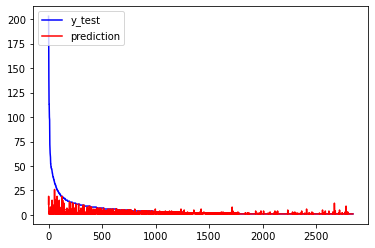

      actual  predicted
0        231         40
1        169          4
2        133          2
3        131         93
4        115          2
...      ...        ...
2461       1          1
2462       1          2
2463       1          1
2464       1          1
2465       1          1

[2466 rows x 2 columns]
0.4959448499594485


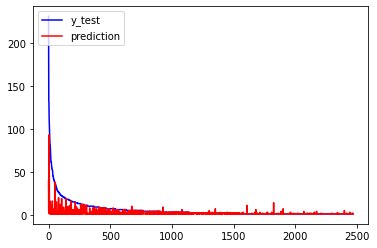

    actual  predicted
0       20         11
1       19         14
2       18         16
3       17         13
4       16         14
5       15          9
6       14          7
7       14          8
8       13         10
9       12         11
10      11         11
11      10          9
12       9          9
13       8          0
14       7          6
15       6          4
16       5          2
17       4          4
18       3          2
19       2          2
20       1          0
21       0          0
0.22727272727272727


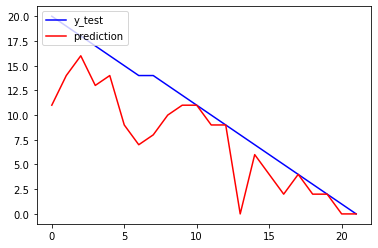

In [95]:
d1 = data_iconCategory()
d2 = data_startTime()
d3 = data_from()
d4 = data_to()
d5 = searchData('2021-04-26')
knn_classifier(d1)
knn_classifier(d2)
knn_classifier(d3)
knn_classifier(d4)
knn_classifier(d5)
